In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# =====================================================
# STEP 1 — LOAD DATA
# =====================================================

train_path = "/content/drive/MyDrive/ML_Project/MultinomialClassification/Dataset/train.csv"
test_path  = "/content/drive/MyDrive/ML_Project/MultinomialClassification/Dataset/test.csv"



df_raw = pd.read_csv(train_path)
test_raw = pd.read_csv(test_path)

TARGET = "spend_category"
ID_COL = "trip_id"

print("Original Training Shape:", df_raw.shape)
print("Original Test Shape:", test_raw.shape)


# =====================================================
# HELPER — Convert Range (15-30, 90+) to numeric
# =====================================================
def range_to_mid(x):
    x = str(x).strip()
    if x.lower() in ["none", "", "nan", "null"]:
        return np.nan
    if "+" in x:
        return float(x.replace("+", ""))
    if "-" in x:
        a, b = x.split("-")
        return (float(a) + float(b)) / 2
    try:
        return float(x)
    except:
        return np.nan


# =====================================================
# STEP 2 — GLOBAL COLUMN DEFINITIONS
# =====================================================
binary_cols = [
    "is_first_visit","intl_transport_included","accomodation_included",
    "food_included","domestic_transport_included","sightseeing_included",
    "guide_included","insurance_included"
]

categorical_cols = [
    "country","age_group","travel_companions","main_activity",
    "visit_purpose","tour_type","info_source","arrival_weather"
]

numeric_count_cols = ["num_females","num_males","mainland_stay_nights","island_stay_nights"]


# =====================================================
# STEP 3 — REMOVE NULL TARGETS FIRST
# =====================================================
removed_target_nulls = df_raw[TARGET].isnull().sum()
print("Rows removed due to null spend_category:", removed_target_nulls)

df_raw = df_raw[df_raw[TARGET].notnull()].reset_index(drop=True)
print("Training shape after removing null targets:", df_raw.shape)


# =====================================================
# STEP 4 — MAIN PREPROCESSING FUNCTION
# =====================================================
def preprocess_raw_df(df):
    df = df.copy()

    # Clean strings
    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].astype(str).str.strip().str.rstrip(',')

    # Binary processing
    for c in binary_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip().str.lower()
            df[c] = df[c].replace({
                "yes": 1,
                "no": 0,
                "nan": np.nan,
                "none": np.nan,
                "null": np.nan,
                "": np.nan
            })
            df[c] = df[c].fillna(0).astype(int)

    # Numeric count fields
    for c in numeric_count_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    # =====================================================
    # SAFE ORDINAL ENCODING FOR RANGE COLUMNS
    # =====================================================

    # Clean weird string values
    def clean_str(x):
        x = str(x).strip().lower()
        if x in ["nan", "none", "null", ""]:
            return np.nan
        return x

    # Clean raw string columns
    if "days_booked_before_trip" in df.columns:
        df["days_booked_before_trip_clean"] = df["days_booked_before_trip"].apply(clean_str)

    if "total_trip_days" in df.columns:
        df["total_trip_days_clean"] = df["total_trip_days"].apply(clean_str)

    # Define ordinal mappings
    ordinal_days_booked = {
        "1-7": 1,
        "8-14": 2,
        "15-30": 3,
        "31-60": 4,
        "61-90": 5,
        "90+": 6
    }

    ordinal_total_trip = {
        "1-6": 1,
        "7-14": 2,
        "15-30": 3,
        "30+": 4
    }

    # Map → Fill Missing → Convert to int
    if "days_booked_before_trip_clean" in df.columns:
        df["days_booked_before_trip_ord"] = (
            df["days_booked_before_trip_clean"]
                .map(ordinal_days_booked)
        )

        # Fill NaN with mode **of ordinal values**
        df["days_booked_before_trip_ord"].fillna(
            df["days_booked_before_trip_ord"].mode()[0],
            inplace=True
        )

        df["days_booked_before_trip_ord"] = df["days_booked_before_trip_ord"].astype(int)

    if "total_trip_days_clean" in df.columns:
        df["total_trip_days_ord"] = (
            df["total_trip_days_clean"]
                .map(ordinal_total_trip)
        )

        # Fill NaN with mode of ordinal values
        df["total_trip_days_ord"].fillna(
            df["total_trip_days_ord"].mode()[0],
            inplace=True
        )

        df["total_trip_days_ord"] = df["total_trip_days_ord"].astype(int)



    # Special requirements → binary
    if "has_special_requirements" in df.columns:
        df["has_special_req_bin"] = df["has_special_requirements"].astype(str).apply(
            lambda x: 0 if x.lower() in ["none", "", "nan"] else 1
        )

    return df


# =====================================================
# APPLY PREPROCESSING TO TRAIN & TEST
# =====================================================
df = preprocess_raw_df(df_raw).reset_index(drop=True)
test_df = preprocess_raw_df(test_raw).reset_index(drop=True)

print("\nAfter Base Preprocessing:")
print(df.shape)


# =====================================================
# STEP 5 — IMPUTATIONS (NO NaNs must remain)
# =====================================================

# Categorical mode fill
for c in categorical_cols:
    if c in df.columns:
        mode = df[c].mode()[0]
        df[c] = df[c].fillna(mode)
        test_df[c] = test_df[c].fillna(mode)

# =========================================================
# OUTLIER REMOVAL (TRAIN ONLY)
# And count number of rows removed per condition
# =========================================================

clean_df = df.copy()
initial_rows = len(clean_df)

outlier_info = {}

# ----- num_females ≤ 14 -----
before = len(clean_df)
clean_df = clean_df[clean_df["num_females"] <= 10]
after = len(clean_df)
outlier_info["num_females"] = before - after

# ----- Rule 1: num_males ≤ 13 -----
before = len(clean_df)
clean_df = clean_df[clean_df["num_males"] <= 10]
after_rule1 = len(clean_df)
removed_rule1 = before - after_rule1
before_rule2 = len(clean_df)

# Save results
outlier_info["num_males_threshold"] = removed_rule1
print("Removed (num_males > 20):", removed_rule1)


# ----- mainland_stay_nights ≤ 100 -----
before = len(clean_df)
clean_df = clean_df[clean_df["mainland_stay_nights"] <= 90]
after = len(clean_df)
outlier_info["mainland_stay_nights"] = before - after

# ----- island_stay_nights ≤ 21 -----
before = len(clean_df)
clean_df = clean_df[clean_df["island_stay_nights"] <= 60]
after = len(clean_df)
outlier_info["island_stay_nights"] = before - after

final_rows = len(clean_df)

# =========================================================
# PRINT OUTLIER REMOVAL SUMMARY
# =========================================================
print("\n========== OUTLIER REMOVAL SUMMARY ==========")
for col, removed in outlier_info.items():
    print(f"{col}: removed {removed} rows")

print("---------------------------------------------")
print(f"Total rows removed: {initial_rows - final_rows}")
print(f"Final Training Shape after Outlier Removal: {clean_df.shape}")
print("Test Shape (unchanged):", test_df.shape)


# =====================================================
# STEP 5 — FINAL FEATURE DEFINITIONS (No NaNs left)
# =====================================================

numeric_features = [
    "num_females",
    "num_males",
    "mainland_stay_nights",
    "island_stay_nights",
    "days_booked_before_trip_ord",
    "total_trip_days_ord"
]

binary_features = binary_cols + ["has_special_req_bin"]

categorical_features = categorical_cols

all_features = numeric_features + binary_features + categorical_features

clean_df = clean_df[all_features + [TARGET]]
test_df_final = test_df[all_features]




Original Training Shape: (12654, 25)
Original Test Shape: (5852, 24)
Rows removed due to null spend_category: 34
Training shape after removing null targets: (12620, 25)


/tmp/ipython-input-1170839011.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].replace({
/tmp/ipython-input-1170839011.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] = df[c].replace({
/tmp/ipython-input-1170839011.py:91: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[c] =


After Base Preprocessing:
(12620, 30)
Removed (num_males > 20): 8

========== OUTLIER REMOVAL SUMMARY ==========
num_females: removed 28 rows
num_males_threshold: removed 8 rows
mainland_stay_nights: removed 27 rows
island_stay_nights: removed 8 rows
---------------------------------------------
Total rows removed: 71
Final Training Shape after Outlier Removal: (12549, 30)
Test Shape (unchanged): (5852, 29)



=== KMeans Visualization: Determine Best K ===


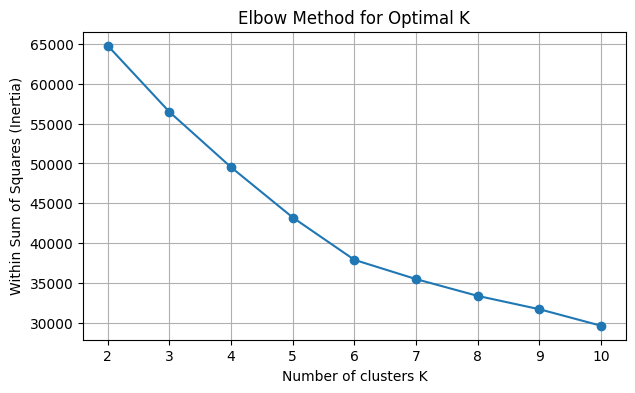

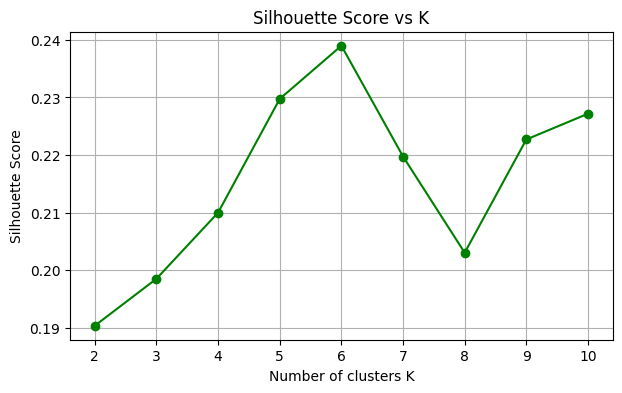


🔍 Best K from Silhouette Score = 6


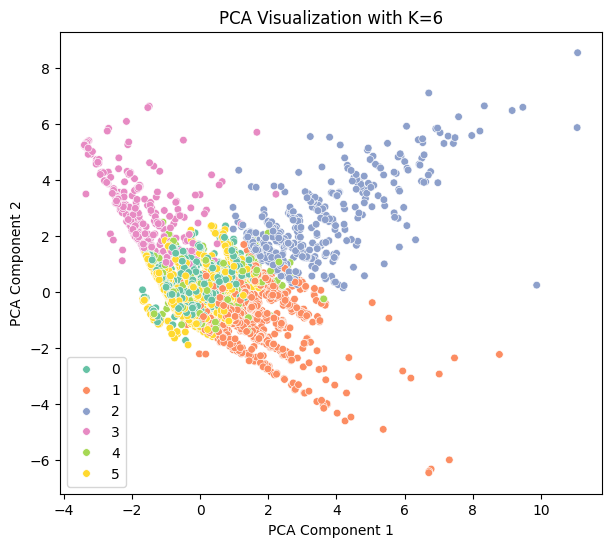


Visualization Completed. Choose the best K based on:
→ Elbow plot (look for a bend)
→ Silhouette peak
→ PCA cluster separation



In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n=== KMeans Visualization: Determine Best K ===")

# ------------------------------------------
# 1. Take numeric data & standardize
# ------------------------------------------
num_data = clean_df[numeric_features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_data)

# ------------------------------------------
# 2. Elbow Curve (Inertia)
# ------------------------------------------
wss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wss.append(kmeans.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(K_range, wss, 'o-')
plt.xlabel("Number of clusters K")
plt.ylabel("Within Sum of Squares (Inertia)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

# ------------------------------------------
# 3. Silhouette Score for each K
# ------------------------------------------
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

plt.figure(figsize=(7, 4))
plt.plot(K_range, sil_scores, 'o-', color='green')
plt.xlabel("Number of clusters K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.grid(True)
plt.show()

# ------------------------------------------
# 4. PCA 2D Visualization
# ------------------------------------------

# Take best K as silhouette maximum
best_k = K_range[np.argmax(sil_scores)]
print(f"\n🔍 Best K from Silhouette Score = {best_k}")

kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_best.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=cluster_labels,
    palette="Set2",
    s=30
)
plt.title(f"PCA Visualization with K={best_k}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

print("\nVisualization Completed. Choose the best K based on:")
print("→ Elbow plot (look for a bend)")
print("→ Silhouette peak")
print("→ PCA cluster separation\n")


In [3]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# =====================================================
# STEP X — FEATURE ENGINEERING: K-Means + GMM CLUSTERS
# =====================================================

print("\n=== Running Clustering Feature Engineering (KMeans + GMM) ===")

# ----------------------------
# 1. Prepare numeric data only
# ----------------------------
num_only = clean_df[numeric_features].copy()
test_num_only = test_df_final[numeric_features].copy()

# Standardize for clustering
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_only)
test_num_scaled = scaler.transform(test_num_only)

# ----------------------------
# 2. K-Means Clustering
# ----------------------------
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
clean_df["kmeans_cluster"] = kmeans.fit_predict(num_scaled)
test_df_final["kmeans_cluster"] = kmeans.predict(test_num_scaled)

# # ----------------------------
# # 3. Gaussian Mixture Model (GMM)
# # ----------------------------
# gmm = GaussianMixture(n_components=5, random_state=42)
# clean_df["gmm_cluster"] = gmm.fit_predict(num_scaled)
# test_df_final["gmm_cluster"] = gmm.predict(test_num_scaled)

print("Clustering features added: kmeans_cluster, gmm_cluster")

# Add to categorical features
# categorical_features += ["kmeans_cluster", "gmm_cluster"]
categorical_features += ["kmeans_cluster"]

# Update full feature list
all_features = numeric_features + binary_features + categorical_features

# Important: keep only final columns
clean_df = clean_df[all_features + [TARGET]]
test_df_final = test_df_final[all_features]

print("\nFinal shape after clustering:", clean_df.shape)



=== Running Clustering Feature Engineering (KMeans + GMM) ===
Clustering features added: kmeans_cluster, gmm_cluster

Final shape after clustering: (12549, 25)


/tmp/ipython-input-4072071504.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_final["kmeans_cluster"] = kmeans.predict(test_num_scaled)


In [4]:

BASE = "/content/drive/MyDrive/ML_Project/MultinomialClassification/MulticlassLR_With6k-meansClusteringChanged"

# =====================================================
# CORRECT SPLITTING ACCORDING TO YOUR REQUIREMENT
# =====================================================

from sklearn.model_selection import train_test_split

# ----------- FULL DATASET -----------
full_df = clean_df.copy()

# =====================================================
# SPLIT A: 80% train, 10% val, 10% test
# =====================================================

# First: 80% train, 20% temp
train_80, temp_20 = train_test_split(
    full_df,
    test_size=0.20,
    stratify=full_df[TARGET],
    random_state=42
)

# Now split 20% temp → 10% val + 10% test
val_10, test_10 = train_test_split(
    temp_20,
    test_size=0.50,   # half of 20%
    stratify=temp_20[TARGET],
    random_state=42
)

print("Split A (80/10/10):")
print("train_80:", train_80.shape)
print("val_10:", val_10.shape)
print("test_10:", test_10.shape)


# =====================================================
# SPLIT B: 20% train, 40% val, 40% test
# =====================================================

# First: 20% train, 80% temp
train_20, temp_80 = train_test_split(
    full_df,
    test_size=0.80,
    stratify=full_df[TARGET],
    random_state=42
)

# Now split 80% temp → 40% val + 40% test
val_40, test_40 = train_test_split(
    temp_80,
    test_size=0.50,
    stratify=temp_80[TARGET],
    random_state=42
)

# =====================================================
# STEP 6 — FUNCTION TO MAKE SKEWED AND NON-SKEWED
# =====================================================
def make_skewed(df):
    # keep natural distribution
    return df.copy()

def make_nonskewed(df):
    # upsample minority classes
    major_size = df[TARGET].value_counts().max()
    frames = []
    for cls in df[TARGET].unique():
        cls_df = df[df[TARGET]==cls]
        cls_up = resample(cls_df, replace=True, n_samples=major_size, random_state=42)
        frames.append(cls_up)
    return pd.concat(frames)

# =====================================================
# STEP 7 — PIPELINE (OHE + SCALER + MULTINOMIAL LR)
# =====================================================
preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("bin", "passthrough", binary_features)
])

model = LogisticRegression(
    multi_class='multinomial',
    max_iter=500,
    solver='lbfgs'
)

pipe = Pipeline([
    ("prep", preprocess),
    ("lr", model)
])

# =====================================================
# STEP 8 — TRAINING FUNCTION
# =====================================================
def run_and_save(mode_name, train_df, val_df, folder):

    os.makedirs(folder, exist_ok=True)

    X_train = train_df[all_features]
    y_train = train_df[TARGET]

    X_val = val_df[all_features]
    y_val = val_df[TARGET]

    # Train
    pipe.fit(X_train, y_train)

    # Validation results
    val_pred = pipe.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)

    # Save val classification report
    with open(f"{folder}/val_classification_report.txt", "w") as f:
        f.write(classification_report(y_val, val_pred))

    # Train accuracy
    train_pred = pipe.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)

    # Save accuracy summary
    with open(f"{folder}/accuracy_summary.txt", "w") as f:
        f.write(f"Train accuracy: {train_acc}\n")
        f.write(f"Validation accuracy: {val_acc}\n")

    # Predict test dataset
    final_pred = pipe.predict(test_df_final)

    pd.DataFrame({
        ID_COL: test_df[ID_COL],
        TARGET: final_pred
    }).to_csv(f"{folder}/predictions_{mode_name}.csv", index=False)

    print(f"Completed → {mode_name}")

# =====================================================
# STEP 9 — RUN ALL 4 MODES
# =====================================================


os.makedirs(BASE, exist_ok=True)

tasks = [
    ("80_skewed",     make_skewed(train_80),     val_10),
    ("80_nonskewed",  make_nonskewed(train_80),  val_10),
    ("20_skewed",     make_skewed(train_20),     val_40),
    ("20_nonskewed",  make_nonskewed(train_20),  val_40),
]

for name, tr, va in tasks:
    folder = f"{BASE}/{name}"
    run_and_save(name, tr, va, folder)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Split A (80/10/10):
train_80: (10039, 25)
val_10: (1255, 25)
test_10: (1255, 25)
Completed → 80_skewed


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Completed → 80_nonskewed
Completed → 20_skewed


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Completed → 20_nonskewed
